<h1><center>Autoencoder on MNIST using Keras<center></h1>

In [255]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

## Importing Keras

In [256]:
import tensorflow as tf
import tensorflow.keras as keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 1.10.0
Using keras version 2.1.6-tf


## Loading and preparing the MNIST dataset

Load the MNIST dataset via keras.datasets. Again, turn train and test labels into one-hot encoding, and reshape and normalize data as in the first exercise. 

In [207]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)

from keras.datasets import mnist
# START CODE HERE

from keras.datasets import mnist
(x_train, y_train),(x_test, y_test) =mnist.load_data(path="mnist.npz")

#END CODE HERE

In [208]:
# Do you remember about one-hot encoding ?
from keras.utils.np_utils import to_categorical

# START CODE HERE
from keras.utils.np_utils import to_categorical

boolean = True
if boolean:
    y_train, y_test = to_categorical(y_train),to_categorical(y_test)
    boolean = False
y_train

# END CODE HERE

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [5]:
x_train.shape

(60000, 28, 28)

In [34]:
x_test.shape

(10000, 28, 28)

In [221]:
# Reshape to proper images with 1 color channel according to backend scheme

# START CODE HERE

train_images = x_train.reshape(60000,-1)
test_images=x_test.reshape(10000,-1)

# END CODE HERE

# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')


# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?

# START CODE HERE

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_images = scaler.fit_transform(train_images)
test_images = scaler.transform(test_images)

print("\nNew mean of the train_image: ",np.mean(train_images))
print("New std of the train_image: ",np.std(train_images))

print("\nNew mean of the test_image: ",np.mean(test_images))
print("New std of the test_image: ",np.std(test_images))

# END CODE HERE


New mean of the train_image:  -1.7174248e-09
New std of the train_image:  0.95633847

New mean of the test_image:  0.0024957662
New std of the test_image:  0.9571717


## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:

Text(0.5, 1.0, 'PCA2')

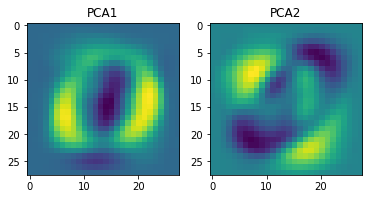

In [223]:

from sklearn.decomposition import PCA
# Let's find the first 2 PCA components
num_components = 2
# START CODE HERE
from sklearn import decomposition

pca = decomposition.PCA(n_components=num_components)
train_images_pca=pca.fit_transform(train_images)

pca1,pca2=pca.components_

# END CODE HERE

# Reshape so they resemble images and we can print them
# START CODE HERE

pca1=pca1.reshape(28,28)
pca2=pca2.reshape(28,28)

# END CODE HERE

# Show the reshaped principal components
# START CODE HERE

fig, axes = plt.subplots(1, 2, figsize=(6,6))

ax = axes[0]
ax.imshow(pca1)
ax.set_title("PCA1")

ax = axes[1]
ax.imshow(pca2)
ax.set_title("PCA2")

# END CODE HERE

In [224]:
# Print the variance explained by those components
pca.explained_variance_

array([40.48894 , 29.241362], dtype=float32)

**Comment on the visualization in relation to the variance explained by only keeping the two principal components.**

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 

In [226]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

In [227]:
# Input layer
input_layer = Input(shape=(784,))

In [228]:
# Encoding layer
latent_view = Dense(2)(input_layer)

In [229]:
# Decoding layer
output_layer = Dense(784, activation='sigmoid')(latent_view)

In [230]:
ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 1570      
_________________________________________________________________
dense_34 (Dense)             (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples.  

##### We use Mean Squarred Error as Loss function because our data isn't normalized between [0,1].

In [231]:
from tensorflow.keras.losses import MSE

loss = 'MSE'
optimizer = SGD(lr=1e-1)

ae_model.compile(optimizer=optimizer, loss=loss) 

In [233]:
batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images,test_images))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 67us/step - loss: 1.0102 - val_loss: 1.0039
Epoch 2/10
60000/60000 [==============================] - 4s 61us/step - loss: 0.9958 - val_loss: 0.9878
Epoch 3/10
60000/60000 [==============================] - 4s 66us/step - loss: 0.9778 - val_loss: 0.9678
Epoch 4/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.9563 - val_loss: 0.9456
Epoch 5/10
60000/60000 [==============================] - 4s 63us/step - loss: 0.9346 - val_loss: 0.9254
Epoch 6/10
60000/60000 [==============================] - 4s 65us/step - loss: 0.9169 - val_loss: 0.9103
Epoch 7/10
60000/60000 [==============================] - 4s 69us/step - loss: 0.9043 - val_loss: 0.8999
Epoch 8/10
60000/60000 [==============================] - 4s 59us/step - loss: 0.8956 - val_loss: 0.8927
Epoch 9/10
60000/60000 [==============================] - 4s 62us/step - loss: 0.8896 - val_loss: 0.8877
Epoch

In [234]:
ae_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 1570      
_________________________________________________________________
dense_34 (Dense)             (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

In [236]:
layer='dense_33'
weights, bias = ae_model.get_layer(layer).get_weights()

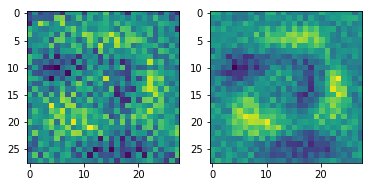

In [237]:
# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)
# START CODE HERE
fig, axes = plt.subplots(1, 2, figsize=(6,6))
ax=axes[0]
ax.imshow(weights.T[0].reshape(28,28))

ax=axes[1]
ax.imshow(weights.T[1].reshape(28,28))

# END CODE HERE

Now, visualize the images rebuild by the network !

In [238]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)


In [ ]:
# Plot a few images from n  
f, axe = plt.subplots(1,5, figsize=(10,10))
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax = axe[i]
    ax.imshow(test_images[a].reshape(28,28))
    ax.set_title("Before")
    # END CODE HERE

In [ ]:
# Get the prediction from the model 
# START CODE HERE
predictions=ae_model.predict(test_images)
# END CODE HERE

# ... and plot them 
f, ax = plt.subplots(1,5,figsize=(10,10))
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    axe= ax[i]
    axe.imshow(predictions[a].reshape(28,28))
    axe.set_title("Rebuilt")
    # END CODE HERE

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 110us/step - loss: 1.1617 - val_loss: 1.1509
Epoch 2/10
60000/60000 [==============================] - 6s 102us/step - loss: 1.1384 - val_loss: 1.1205
Epoch 3/10
60000/60000 [==============================] - 6s 99us/step - loss: 1.0993 - val_loss: 1.0764
Epoch 4/10
60000/60000 [==============================] - 6s 100us/step - loss: 1.0564 - val_loss: 1.0380
Epoch 5/10
60000/60000 [==============================] - 6s 101us/step - loss: 1.0211 - val_loss: 1.0059
Epoch 6/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.9904 - val_loss: 0.9759
Epoch 7/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.9602 - val_loss: 0.9444
Epoch 8/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.9273 - val_loss: 0.9092
Epoch 9/10
60000/60000 [==============================] - 6s 99us/step - loss: 0.8908 - val_loss: 0.871

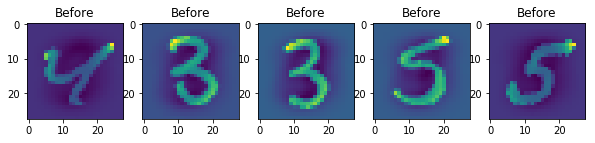

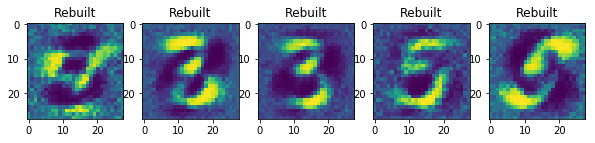

In [271]:
# START CODE HERE

#NEW LATENT
latent_view_high_dim = Dense(32)(input_layer)
output_layer = Dense(784, activation='sigmoid')(latent_view_high_dim)
ae_model_high_dim = Model(input_layer, output_layer, name='ae_model')

#COMPILE
ae_model_high_dim.compile(optimizer=optimizer, loss=loss) 

#FIT 10 EPOCH
batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model_high_dim.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images,test_images))

#PRINT RANDOM IMAGES REBUILT
n = np.random.randint(0,len(test_images)-5)
predictions_high_dim=ae_model_high_dim.predict(test_images)

f, axe = plt.subplots(1,5, figsize=(10,10))
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax = axe[i]
    ax.imshow(test_images[a].reshape(28,28))
    ax.set_title("Before")
    
f, axe = plt.subplots(1,5, figsize=(10,10))
for i,a in enumerate(range(n,n+5)):
    ax = axe[i]
    ax.imshow(predictions_high_dim[a].reshape(28,28))
    ax.set_title("Rebuilt")
    
# END CODE HERE

##### Much better with high dimensions !

## Denoising auto-encoder 

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built. 

In [258]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [259]:
# Create a copy of the data with added noise
noisy_train_images = noise(train_images)
noisy_test_images = noise(test_images)

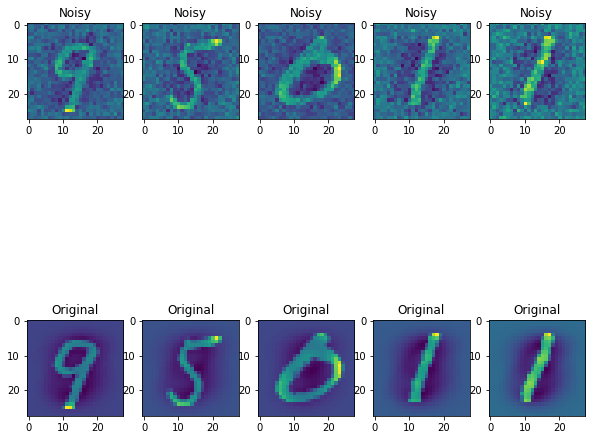

In [260]:
# Visualize some of the images with noise against the originals
# START CODE HERE

# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)
predictions=ae_model.predict(test_images)

# Plot a few images from n  
f, axe = plt.subplots(2,5, figsize=(10,10))
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax = axe[0,i]
    ax.imshow(noisy_train_images[a].reshape(28,28))
    ax.set_title("Noisy")
    ax = axe[1,i]
    ax.imshow(train_images[a].reshape(28,28),label='Original')
    ax.set_title("Original")

    # END CODE HERE

# END CODE HERE

In [261]:
# Build a new model with more layers and Relu activations
# START CODE HERE

#NEW LATENT
latent_view_noisy = Dense(32)(input_layer)
output_layer = Dense(784, activation='relu')(latent_view_noisy)
ae_model_noisy = Model(input_layer, output_layer, name='ae_model_noisy')

    
# END CODE HERE
# END CODE HERE

In [266]:
# Compile it but here, use noised data as inputs !
# START CODE HERE
#COMPILE
ae_model_noisy.compile(optimizer=optimizer, loss=loss) 

#FIT 10 EPOCH
batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model_noisy.fit(noisy_train_images,
                       noisy_train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(noisy_test_images,noisy_test_images))
# END CODE HERE

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 110us/step - loss: 0.4754 - val_loss: 0.4771
Epoch 2/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.4715 - val_loss: 0.4758
Epoch 3/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.4694 - val_loss: 0.4746
Epoch 4/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.4679 - val_loss: 0.4748
Epoch 5/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.4666 - val_loss: 0.4730
Epoch 6/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.4655 - val_loss: 0.4719
Epoch 7/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.4644 - val_loss: 0.4707
Epoch 8/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.4635 - val_loss: 0.4703
Epoch 9/10
60000/60000 [==============================] - 6s 97us/step - loss: 0.4626 - val_loss: 0.4689
Epoc

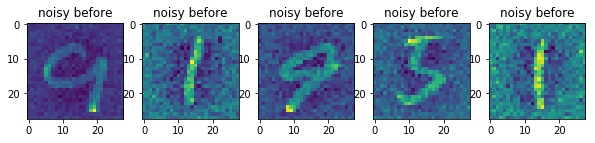

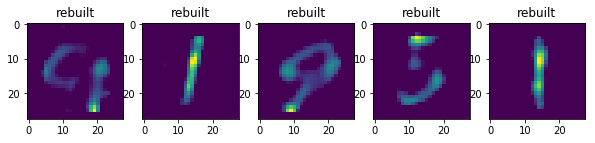

In [269]:
# Visualize the images rebuilt by the model !
# START CODE HERE

#PRINT RANDOM IMAGES REBUILT
n = np.random.randint(0,len(noisy_test_images-5))

predictions_noisy = ae_model_noisy.predict(noisy_test_images)

f, axe = plt.subplots(1,5, figsize=(10,10))
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax = axe[i]
    ax.imshow(noisy_test_images[a].reshape(28,28))
    ax.set_title('noisy before')
    

f, axe = plt.subplots(1,5, figsize=(10,10))
for i,a in enumerate(range(n,n+5)):
    ax = axe[i]
    ax.imshow(predictions_noisy[a].reshape(28,28))
    ax.set_title('rebuilt')
# END CODE HERE


**Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?**

##### We can also use Binary Cross Entropy as the loss function, only if the images are normalized between 0 and 1, here we have a 0 mean so negative value possibly.